In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
import plotly.express as px
import os


In [41]:
# Create output directory for saved visualizations if it doesn't exist
output_dir = r'C:\Users\clint\Desktop\compstak-analysis\Images\Corrected Data'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created/verified: {output_dir}")

Output directory created/verified: C:\Users\clint\Desktop\compstak-analysis\Images\Corrected Data


In [42]:
compstak_df = pd.read_csv(r'C:\Users\clint\Desktop\compstak-analysis\Data\compstak_mapped.csv')
doe_df = pd.read_csv(r'C:\Users\clint\Desktop\compstak-analysis\Data\DOE_mapped.csv')

In [43]:
# Rename 'State' column to 'statecode' in compstak_df for consistent analysis
compstak_df = compstak_df.rename(columns={'State': 'statecode'})

# Verify column names in both dataframes
print("ComptStak DF columns:", compstak_df.columns.tolist())
print("DOE DF columns:", doe_df.columns.tolist())

ComptStak DF columns: ['Property Type', 'Property Subtype', 'Property Id', 'statecode', 'DOE_Compliant_Property_Type']
DOE DF columns: ['statecode', 'reported_propertytype', 'reported_propertysubtype', 'compstak_equivalent_category']


In [44]:
compstak_df

,Property Type,Property Subtype,Property Id,statecode,DOE_Compliant_Property_Type
0,Retail,Parking,1,NY,Other
1,Retail,Apartments,2,NY,Multi-Family
2,Office,NaN,3,NY,Office
3,Retail,NaN,4,NY,Retail
4,Office,Mixed-Use,5,NY,Other
...,...,...,...,...,...
759612,NaN,NaN,3611385,NY,Other
759613,Industrial,Flex/R&D,3611389,FL,Industrial
759614,Industrial,Flex/R&D,3611390,FL,Industrial
759615,NaN,NaN,3611391,CA,Other


In [45]:
doe_df

,statecode,reported_propertytype,reported_propertysubtype,compstak_equivalent_category
0,CT,Flex,Light Manufacturing,Industrial
1,CT,Industrial,Warehouse,Industrial
2,CT,Industrial,NaN,Industrial
3,CT,Multi-Family,Apartments,Multi-Family
4,CT,Multi-Family,Apartments,Multi-Family
...,...,...,...,...
2246480,WI,Retail,Storefront Retail/Office,Retail
2246481,WI,Retail,Storefront Retail/Office,Retail
2246482,WI,Retail,NaN,Retail
2246483,WI,Retail,NaN,Retail


## Coverage Rate Analysis

Analyzing the relationship between the number of properties and coverage rate.
Coverage Rate = (Number of properties in CompStak / Number of properties in DOE) * 100

In [46]:
# Count properties by state in both datasets
compstak_state_counts = compstak_df.groupby('statecode').size().reset_index(name='compstak_count')
doe_state_counts = doe_df.groupby('statecode').size().reset_index(name='doe_count')

# Merge the counts
coverage_df = compstak_state_counts.merge(doe_state_counts, on='statecode', how='outer')

# Fill any NaN values with 0
coverage_df = coverage_df.fillna(0)

# Calculate coverage rate
coverage_df['coverage_rate'] = (coverage_df['compstak_count'] / coverage_df['doe_count']) * 100

# Handle states where DOE has 0 properties
coverage_df['coverage_rate'] = coverage_df['coverage_rate'].replace([np.inf, -np.inf], np.nan)

# Display the coverage dataframe
coverage_df.sort_values('coverage_rate', ascending=False).head(10)

,statecode,compstak_count,doe_count,coverage_rate
33,NV,10816,15179,71.256341
4,CA,162159,238844,67.893269
3,AZ,20836,33274,62.619463
7,DC,2456,4440,55.315315
44,UT,11964,23016,51.981230
37,OR,15008,33979,44.168457
43,TX,64219,157912,40.667587
34,NY,43117,113724,37.913721
14,IL,31389,83364,37.652944
9,FL,54836,145821,37.605009


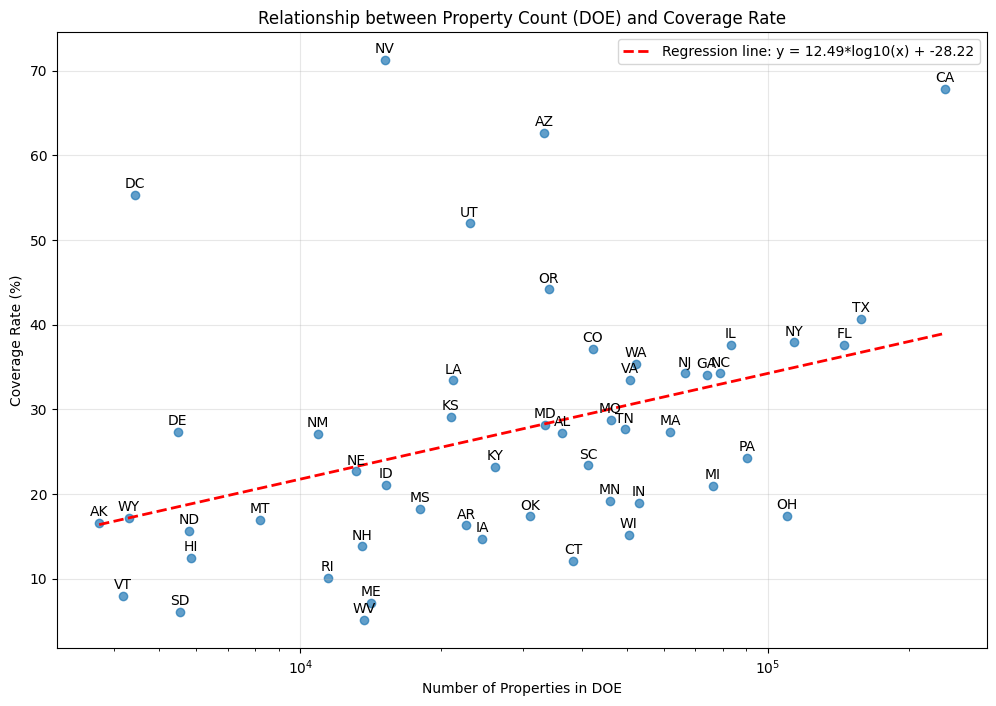

Correlation coefficient (log10 scale): 0.3763
Regression equation: Coverage Rate = 12.4937 * log10(DOE count) + -28.2236


In [47]:
# Create a scatter plot to visualize the relationship between property count and coverage rate
plt.figure(figsize=(12, 8))
plt.scatter(coverage_df['doe_count'], coverage_df['coverage_rate'], alpha=0.7)

# Add regression line
# Use log of x values since we're using log scale
log_x = np.log10(coverage_df['doe_count'])
mask = ~np.isnan(log_x) & ~np.isnan(coverage_df['coverage_rate'])
slope, intercept = np.polyfit(log_x[mask], coverage_df['coverage_rate'][mask], 1)

# Create x values for the line spanning the range of data
x_range = np.logspace(np.log10(coverage_df['doe_count'].min()), 
                     np.log10(coverage_df['doe_count'].max()), 100)
y_range = slope * np.log10(x_range) + intercept

# Plot the regression line
plt.plot(x_range, y_range, 'r--', linewidth=2, 
         label=f'Regression line: y = {slope:.2f}*log10(x) + {intercept:.2f}')

# Add state labels to the points
for i, row in coverage_df.iterrows():
    plt.annotate(row['statecode'], 
                (row['doe_count'], row['coverage_rate']),
                textcoords="offset points",
                xytext=(0,5),
                ha='center')

plt.title('Relationship between Property Count (DOE) and Coverage Rate')
plt.xlabel('Number of Properties in DOE')
plt.ylabel('Coverage Rate (%)')
plt.grid(True, alpha=0.3)
plt.legend()

# Log scale may be useful if data is spread across orders of magnitude
plt.xscale('log')

# Save the figure
plt.savefig(os.path.join(output_dir, 'doe_compstak_coverage_rate_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print the correlation coefficient for log-transformed data
log_corr = np.corrcoef(log_x[mask], coverage_df['coverage_rate'][mask])[0,1]
print(f"Correlation coefficient (log10 scale): {log_corr:.4f}")
print(f"Regression equation: Coverage Rate = {slope:.4f} * log10(DOE count) + {intercept:.4f}")

In [48]:
# Create a bar chart for the top 15 states by coverage rate
top_15_states = coverage_df.sort_values('coverage_rate', ascending=False).head(15)

fig = px.bar(top_15_states, x='statecode', y='coverage_rate',
             hover_data=['compstak_count', 'doe_count'],
             labels={'statecode': 'State Code', 'coverage_rate': 'Coverage Rate (%)'},
             title='Top 15 States by CompStak Coverage Rate',
             color='coverage_rate',
             color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

# Save the figure
fig.write_image(os.path.join(output_dir, 'top_15_states_coverage_rate.png'))

Correlation between DOE property count and coverage rate: 0.4329

Number of states in each coverage rate category:
coverage_category
0-1%        0
1-5%        0
5-10%       4
10-20%     16
20-50%     26
50-100%     5
>100%       0
Name: count, dtype: int64


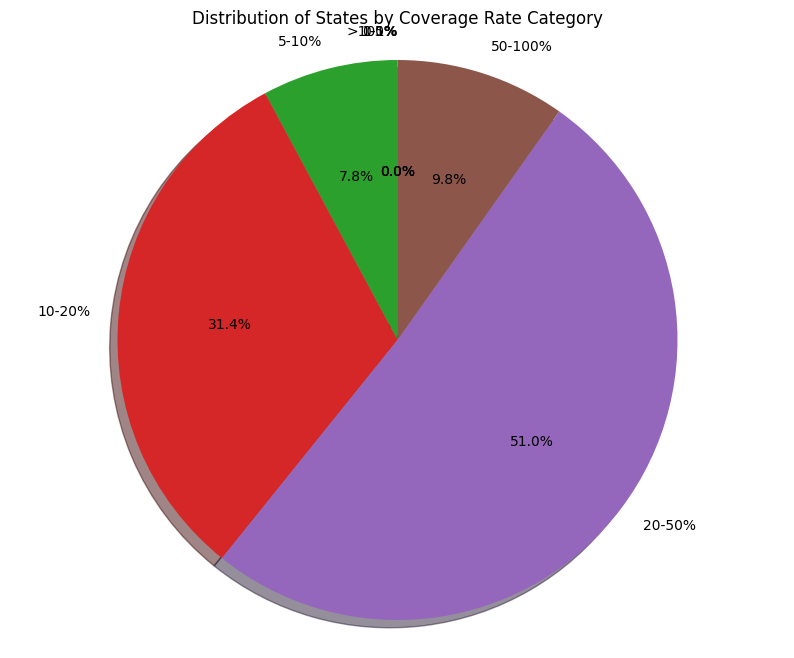

In [49]:
# Analyze correlation between DOE property count and coverage rate
correlation = coverage_df['doe_count'].corr(coverage_df['coverage_rate'])
print(f"Correlation between DOE property count and coverage rate: {correlation:.4f}")

# Group states by coverage rate ranges
bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
labels = ['0-1%', '1-5%', '5-10%', '10-20%', '20-50%', '50-100%', '>100%']
coverage_df['coverage_category'] = pd.cut(coverage_df['coverage_rate'], bins=bins, labels=labels)

# Count states in each category
category_counts = coverage_df['coverage_category'].value_counts().sort_index()
print("\nNumber of states in each coverage rate category:")
print(category_counts)

# Create a pie chart for coverage categories
plt.figure(figsize=(10, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Distribution of States by Coverage Rate Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.savefig(os.path.join(output_dir, 'coverage_rate_distribution_pie.png'), dpi=300, bbox_inches='tight')
plt.show()

## Coverage Rate Analysis by Property Type

Analyzing the relationship between the number of properties and coverage rate by commercial property type.
Using `DOE_Compliant_Property_Type` from the CompStak dataset and `compstak_equivalent_category` from the DOE dataset.

In [50]:
# Count properties by property type in both datasets
compstak_type_counts = compstak_df.groupby('DOE_Compliant_Property_Type').size().reset_index(name='compstak_count')
doe_type_counts = doe_df.groupby('compstak_equivalent_category').size().reset_index(name='doe_count')

# Rename column in doe_type_counts for consistent merging
doe_type_counts = doe_type_counts.rename(columns={'compstak_equivalent_category': 'property_type'})
compstak_type_counts = compstak_type_counts.rename(columns={'DOE_Compliant_Property_Type': 'property_type'})

# Merge the counts
coverage_by_type_df = compstak_type_counts.merge(doe_type_counts, on='property_type', how='outer')

# Fill any NaN values with 0
coverage_by_type_df = coverage_by_type_df.fillna(0)

# Calculate coverage rate
coverage_by_type_df['coverage_rate'] = (coverage_by_type_df['compstak_count'] / coverage_by_type_df['doe_count']) * 100

# Handle property types where DOE has 0 properties
coverage_by_type_df['coverage_rate'] = coverage_by_type_df['coverage_rate'].replace([np.inf, -np.inf], np.nan)

# Display the coverage dataframe
coverage_by_type_df.sort_values('coverage_rate', ascending=False)

,property_type,compstak_count,doe_count,coverage_rate
4,Other,167739,161804,103.668018
2,Multi-Family,114432,253361,45.165594
1,Industrial,183414,438534,41.824351
3,Office,88848,388432,22.873502
5,Retail,195116,931077,20.955947
0,Hotel,10068,73277,13.739645


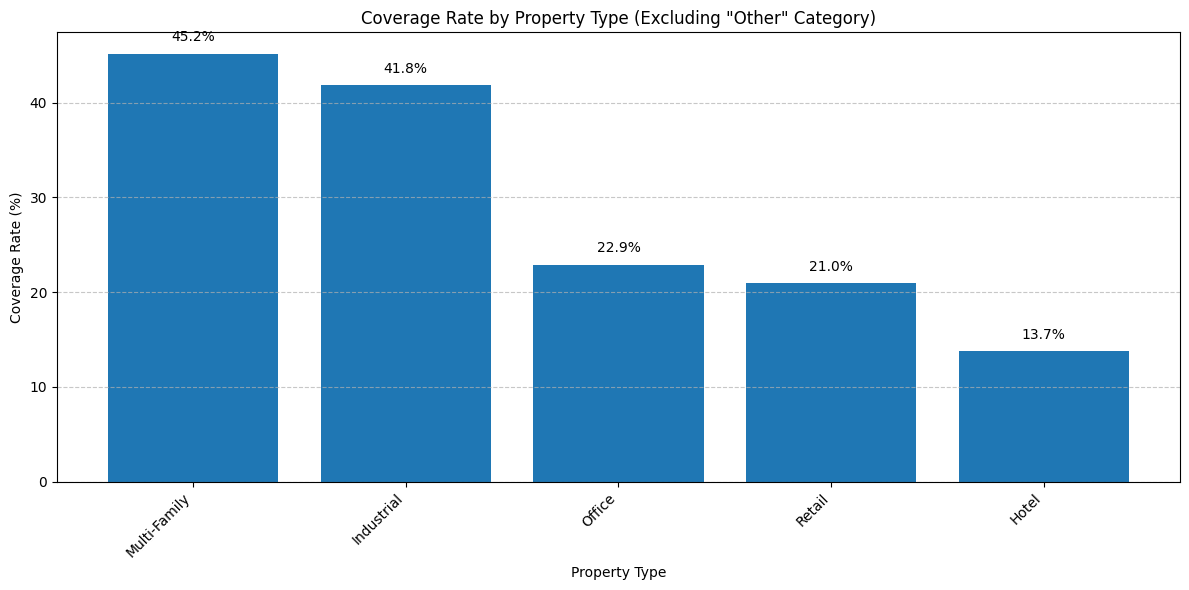

Coverage rates by property type (excluding Other):
Multi-Family: 45.17%
Industrial: 41.82%
Office: 22.87%
Retail: 20.96%
Hotel: 13.74%


In [51]:
# Create a bar chart for the property types by coverage rate
# Filter out 'Other' category
filtered_df = coverage_by_type_df[coverage_by_type_df['property_type'] != 'Other']

plt.figure(figsize=(12, 6))
bars = plt.bar(filtered_df.sort_values('coverage_rate', ascending=False)['property_type'], 
         filtered_df.sort_values('coverage_rate', ascending=False)['coverage_rate'])

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', rotation=0)

plt.title('Coverage Rate by Property Type (Excluding "Other" Category)')
plt.xlabel('Property Type')
plt.ylabel('Coverage Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(output_dir, 'property_type_coverage_rate_bar_no_other.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print the filtered coverage rates
print("Coverage rates by property type (excluding Other):")
for idx, row in filtered_df.sort_values('coverage_rate', ascending=False).iterrows():
    print(f"{row['property_type']}: {row['coverage_rate']:.2f}%")

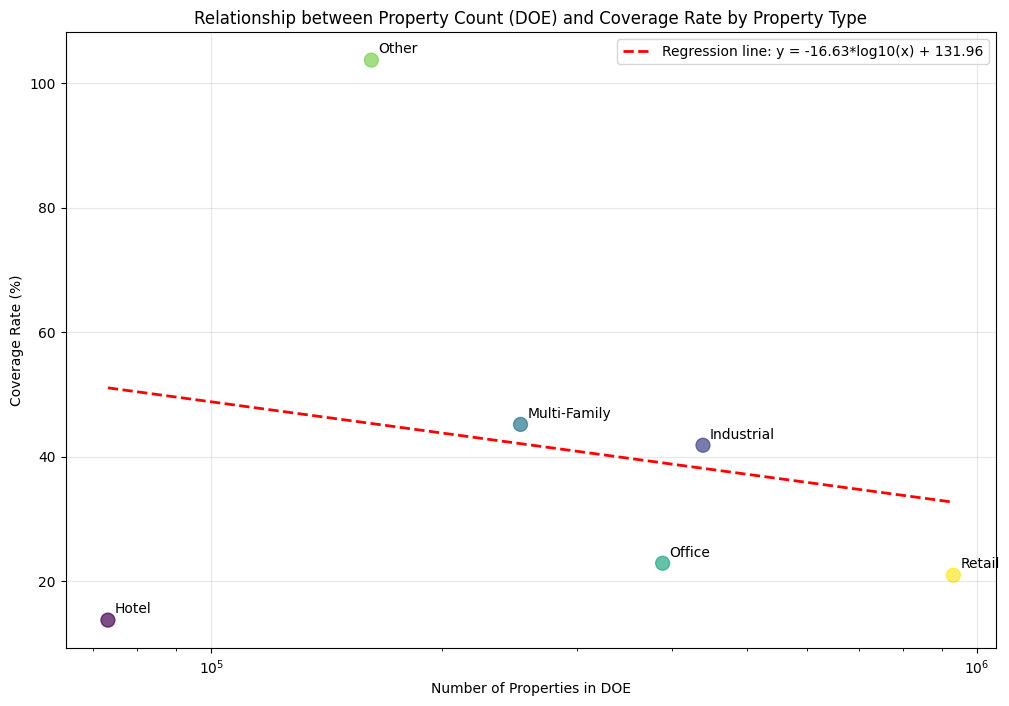

Correlation coefficient (log10 scale) for property types: -0.1928
Regression equation: Coverage Rate = -16.6334 * log10(DOE count) + 131.9623


In [52]:
# Create a scatter plot to visualize the relationship between property count and coverage rate
plt.figure(figsize=(12, 8))
scatter = plt.scatter(coverage_by_type_df['doe_count'], coverage_by_type_df['coverage_rate'], 
              alpha=0.7, s=100, c=range(len(coverage_by_type_df)), cmap='viridis')

# Add property type labels to the points
for i, row in coverage_by_type_df.iterrows():
    plt.annotate(row['property_type'], 
                (row['doe_count'], row['coverage_rate']),
                textcoords="offset points",
                xytext=(5,5),
                ha='left')

# Add regression line
log_x = np.log10(coverage_by_type_df['doe_count'].replace(0, np.nan))
mask = ~np.isnan(log_x) & ~np.isnan(coverage_by_type_df['coverage_rate'])
if sum(mask) > 1:  # Make sure we have at least 2 points for regression
    slope, intercept = np.polyfit(log_x[mask], coverage_by_type_df['coverage_rate'][mask], 1)
    
    # Create x values for the line spanning the range of data
    x_range = np.logspace(np.log10(coverage_by_type_df['doe_count'][coverage_by_type_df['doe_count'] > 0].min()), 
                         np.log10(coverage_by_type_df['doe_count'].max()), 100)
    y_range = slope * np.log10(x_range) + intercept
    
    # Plot the regression line
    plt.plot(x_range, y_range, 'r--', linewidth=2, 
             label=f'Regression line: y = {slope:.2f}*log10(x) + {intercept:.2f}')

plt.title('Relationship between Property Count (DOE) and Coverage Rate by Property Type')
plt.xlabel('Number of Properties in DOE')
plt.ylabel('Coverage Rate (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale('log')

# Save the figure
plt.savefig(os.path.join(output_dir, 'doe_compstak_coverage_rate_by_type_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

if sum(mask) > 1:
    # Print the correlation coefficient for log-transformed data
    log_type_corr = np.corrcoef(log_x[mask], coverage_by_type_df['coverage_rate'][mask])[0,1]
    print(f"Correlation coefficient (log10 scale) for property types: {log_type_corr:.4f}")
    print(f"Regression equation: Coverage Rate = {slope:.4f} * log10(DOE count) + {intercept:.4f}")

In [53]:
# Create interactive bar chart with Plotly
fig = px.bar(coverage_by_type_df.sort_values('coverage_rate', ascending=False), 
             x='property_type', y='coverage_rate',
             hover_data=['compstak_count', 'doe_count'],
             labels={'property_type': 'Property Type', 'coverage_rate': 'Coverage Rate (%)'},
             title='Coverage Rate by Property Type',
             color='coverage_rate',
             color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(
    xaxis={'categoryorder':'total descending'},
    xaxis_tickangle=-45,
    yaxis_title='Coverage Rate (%)'
)

fig.show()

# Save the figure
fig.write_image(os.path.join(output_dir, 'property_type_coverage_rate_plotly.png'))

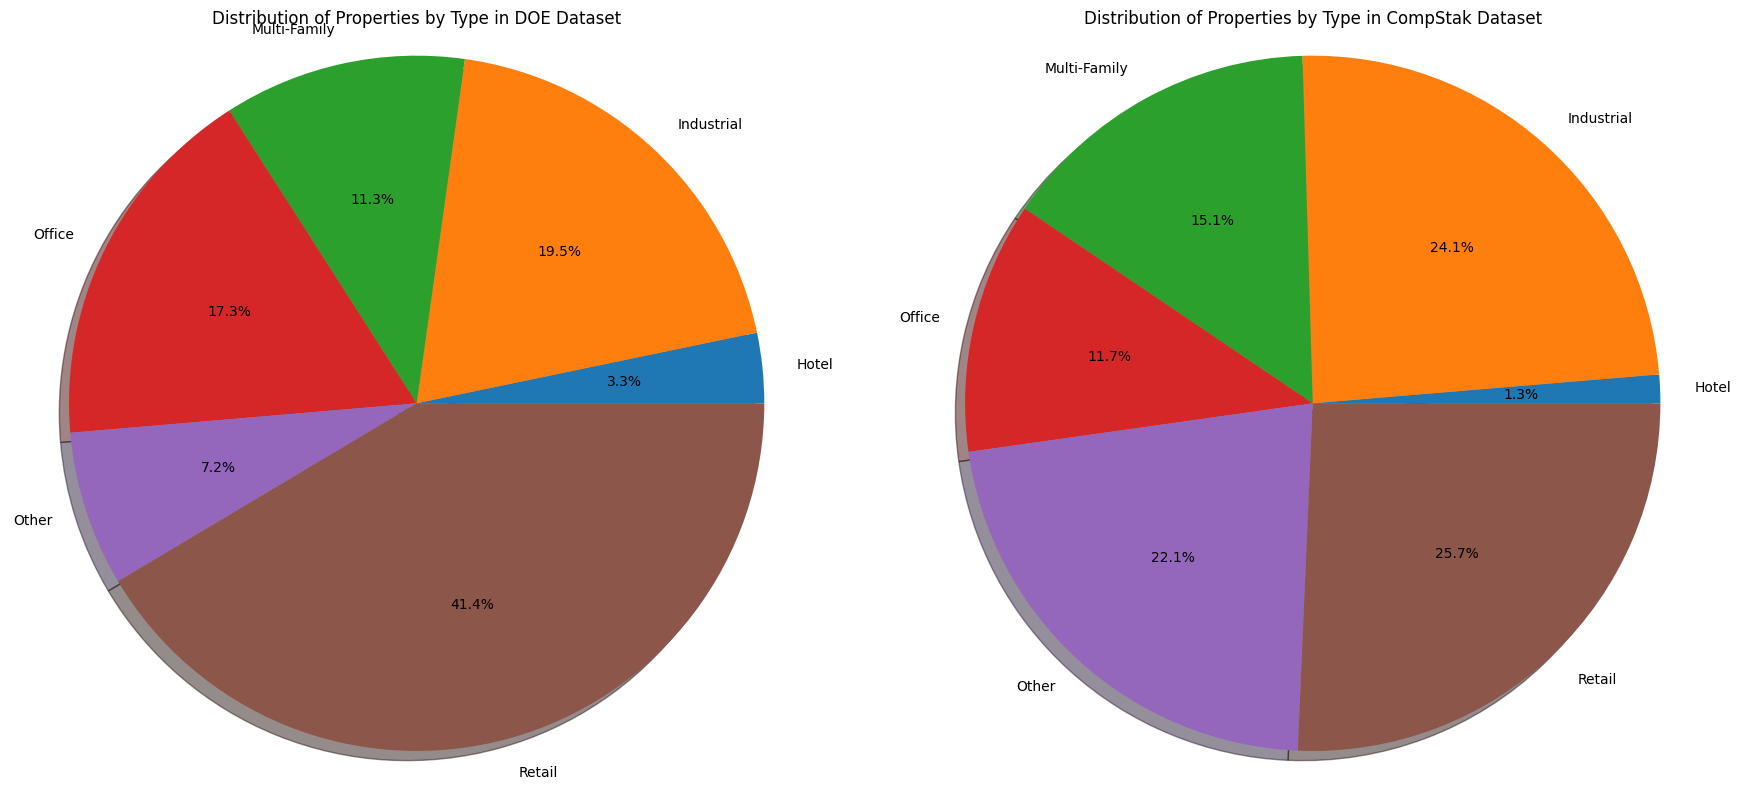

In [54]:
# Create pie charts for property type distribution in both datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# DOE dataset distribution
ax1.pie(doe_type_counts['doe_count'], labels=doe_type_counts['property_type'], autopct='%1.1f%%', shadow=True)
ax1.set_title('Distribution of Properties by Type in DOE Dataset')
ax1.axis('equal')

# CompStak dataset distribution
ax2.pie(compstak_type_counts['compstak_count'], labels=compstak_type_counts['property_type'], autopct='%1.1f%%', shadow=True)
ax2.set_title('Distribution of Properties by Type in CompStak Dataset')
ax2.axis('equal')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'property_type_distribution_comparison_pie.png'), dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# Calculate correlation between DOE property count and coverage rate by type
type_correlation = coverage_by_type_df['doe_count'].corr(coverage_by_type_df['coverage_rate'])
print(f"Correlation between DOE property count and coverage rate by property type: {type_correlation:.4f}")

# Calculate mean and median coverage rates by property type
mean_coverage = coverage_by_type_df['coverage_rate'].mean()
median_coverage = coverage_by_type_df['coverage_rate'].median()
print(f"Mean coverage rate across property types: {mean_coverage:.2f}%")
print(f"Median coverage rate across property types: {median_coverage:.2f}%")

# Create a table comparing property type counts and coverage rates
comparison_table = coverage_by_type_df.copy()
comparison_table['doe_percentage'] = (comparison_table['doe_count'] / comparison_table['doe_count'].sum()) * 100
comparison_table['compstak_percentage'] = (comparison_table['compstak_count'] / comparison_table['compstak_count'].sum()) * 100
comparison_table['representation_diff'] = comparison_table['compstak_percentage'] - comparison_table['doe_percentage']

comparison_table_sorted = comparison_table.sort_values('coverage_rate', ascending=False)
comparison_table_sorted[['property_type', 'doe_count', 'compstak_count', 'coverage_rate', 
                        'doe_percentage', 'compstak_percentage', 'representation_diff']]

Correlation between DOE property count and coverage rate by property type: -0.3384
Mean coverage rate across property types: 41.37%
Median coverage rate across property types: 32.35%


,property_type,doe_count,compstak_count,coverage_rate,doe_percentage,compstak_percentage,representation_diff
4,Other,161804,167739,103.668018,7.202541,22.082049,14.879508
2,Multi-Family,253361,114432,45.165594,11.278108,15.064434,3.786326
1,Industrial,438534,183414,41.824351,19.520896,24.145589,4.624693
3,Office,388432,88848,22.873502,17.290656,11.696421,-5.594236
5,Retail,931077,195116,20.955947,41.445948,25.686102,-15.759845
0,Hotel,73277,10068,13.739645,3.261851,1.325405,-1.936447
